## 1. Import Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Preprocessed Data

In [2]:
# Load the preprocessed data
data = pd.read_csv('BRFSS_preprocessed.csv')
print(f"Data Shape: {data.shape}")
print(f"\nFirst few rows:")
display(data.head())

Data Shape: (727123, 31)

First few rows:


,YEAR,SEX,AGE,WGHT (lbs),HGHT (ft),BMI,EDUCATION_LEVEL,EMPLOYMENT_STATUS,INCOME_LEVEL,MARITAL_STATUS,...,HIGH_BP,BP_MEDS,HIGH_CHOL,CHOL_MEDS,HAD_STROKE,HAD_HEARTDISEASE,DIABETES_STATUS,BMI_CATEGORY,AGE_GROUP,DIABETES_BINARY
0,2023,0,5,172.0,5.25,30.47,4,7,7,1,...,3,1,0,0,0,0,3,3.0,2.0,1
1,2023,0,5,132.0,4.75,28.56,4,7,7,2,...,3,0,1,1,0,0,0,2.0,2.0,0
2,2023,0,5,130.0,5.33,22.34,3,7,2,3,...,3,1,1,1,0,0,0,1.0,2.0,0
3,2023,0,5,170.0,5.50,27.44,4,7,7,1,...,0,1,0,0,0,0,0,2.0,2.0,0
4,2023,0,5,170.0,5.67,25.82,4,0,7,3,...,3,1,0,0,0,0,3,2.0,2.0,1


In [3]:
# Basic info
print("Data Info:")
data.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727123 entries, 0 to 727122
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   YEAR               727123 non-null  int64  
 1   SEX                727123 non-null  int64  
 2   AGE                727123 non-null  int64  
 3   WGHT (lbs)         727123 non-null  float64
 4   HGHT (ft)          727123 non-null  float64
 5   BMI                727123 non-null  float64
 6   EDUCATION_LEVEL    727123 non-null  int64  
 7   EMPLOYMENT_STATUS  727123 non-null  int64  
 8   INCOME_LEVEL       727123 non-null  int64  
 9   MARITAL_STATUS     727123 non-null  int64  
 10  INSR_STATUS        727123 non-null  int64  
 11  DCTR_STATUS        727123 non-null  int64  
 12  COST_STATUS        727123 non-null  int64  
 13  CHKP_STATUS        727123 non-null  int64  
 14  GEN_HLTH           727123 non-null  int64  
 15  PHYS_HLTH_DAYS     727123 non-null  int6

## 3. Target Variable Analysis

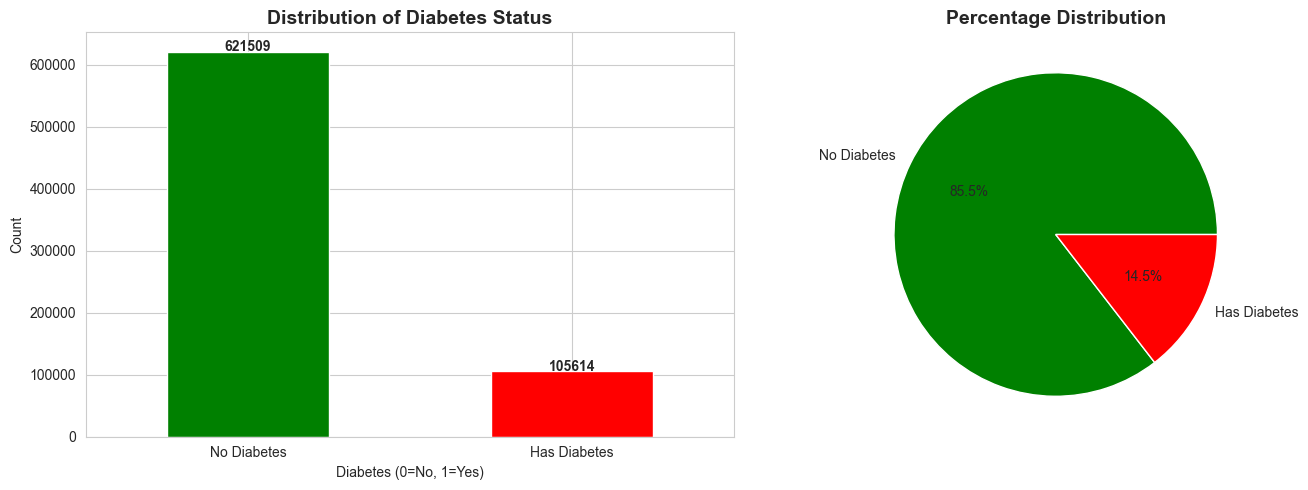


Class Distribution:
DIABETES_BINARY
0    621509
1    105614
Name: count, dtype: int64

Class Balance Ratio: 5.88:1


In [4]:
# Target variable distribution
target = 'DIABETES_BINARY'

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
data[target].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Distribution of Diabetes Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Diabetes (0=No, 1=Yes)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Diabetes', 'Has Diabetes'], rotation=0)

# Add count labels
for i, v in enumerate(data[target].value_counts().values):
    axes[0].text(i, v + 1000, str(v), ha='center', fontweight='bold')

# Pie chart
data[target].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                  colors=['green', 'red'], labels=['No Diabetes', 'Has Diabetes'])
axes[1].set_title('Percentage Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"\nClass Distribution:")
print(data[target].value_counts())
print(f"\nClass Balance Ratio: {data[target].value_counts()[0] / data[target].value_counts()[1]:.2f}:1")

## 4. Univariate Analysis - Numerical Features

In [5]:
# Select numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove(target)  # Remove target
if 'DIABETES_STATUS' in numerical_cols:
    numerical_cols.remove('DIABETES_STATUS')  # Remove original target

print(f"Numerical features ({len(numerical_cols)}): {numerical_cols}")

Numerical features (29): ['YEAR', 'SEX', 'AGE', 'WGHT (lbs)', 'HGHT (ft)', 'BMI', 'EDUCATION_LEVEL', 'EMPLOYMENT_STATUS', 'INCOME_LEVEL', 'MARITAL_STATUS', 'INSR_STATUS', 'DCTR_STATUS', 'COST_STATUS', 'CHKP_STATUS', 'GEN_HLTH', 'PHYS_HLTH_DAYS', 'MENT_HLTH_DAYS', 'POOR_HLTH_DAYS', 'SMOK_STATUS', 'ALHL_STATUS', 'EXER_STATUS', 'HIGH_BP', 'BP_MEDS', 'HIGH_CHOL', 'CHOL_MEDS', 'HAD_STROKE', 'HAD_HEARTDISEASE', 'BMI_CATEGORY', 'AGE_GROUP']


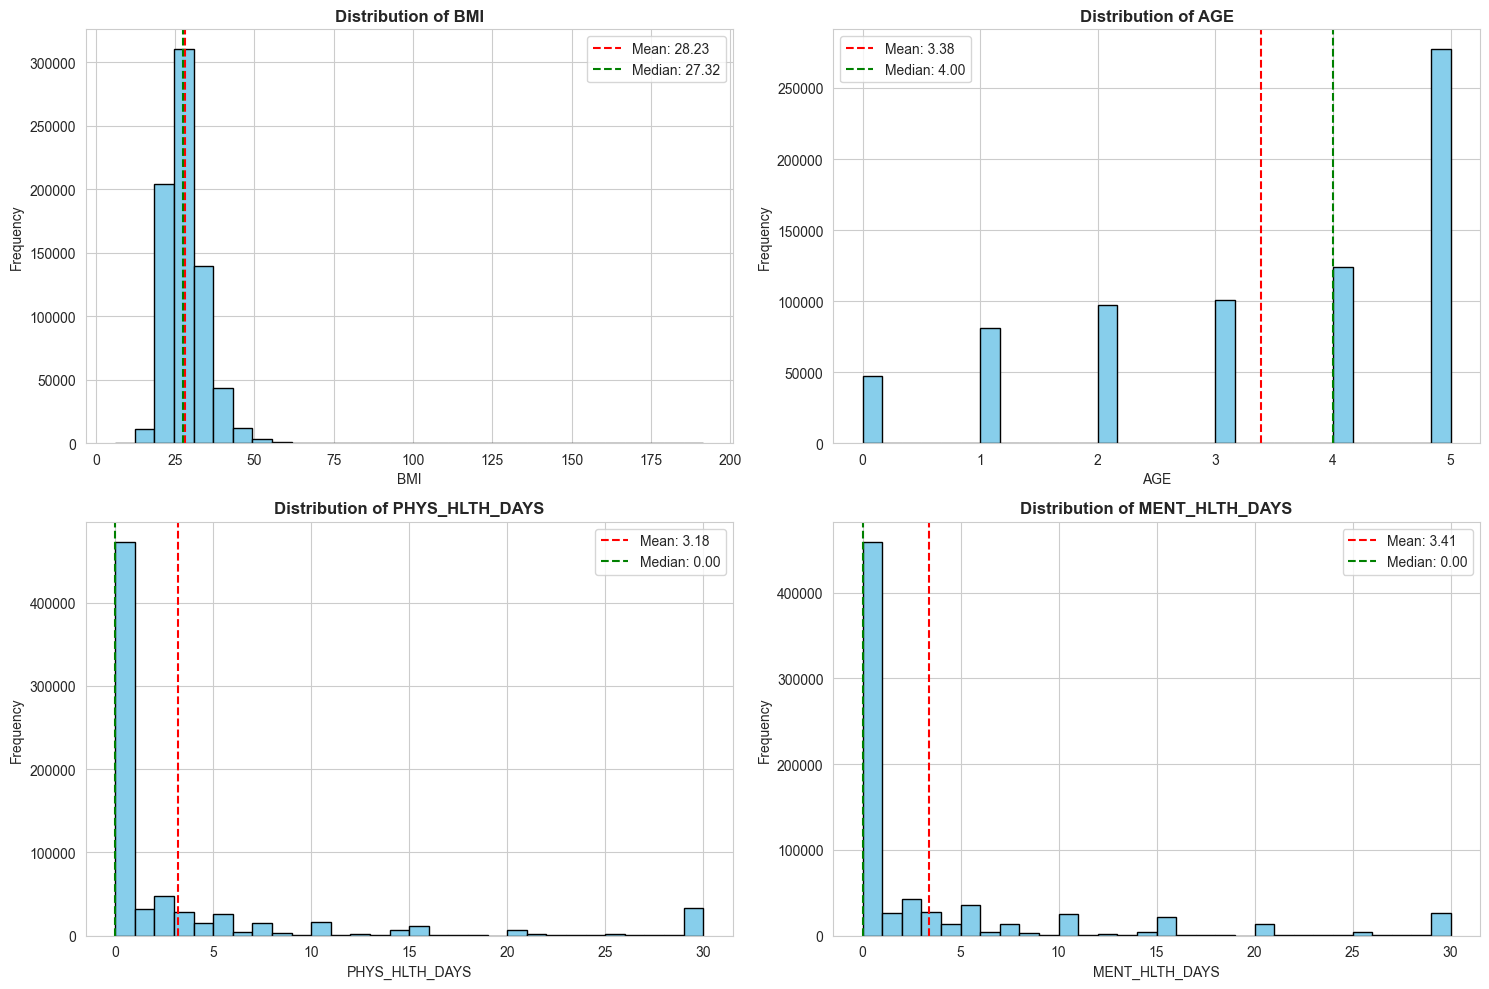

In [6]:
# Distribution of key numerical features
key_numerical = ['BMI', 'AGE', 'PHYS_HLTH_DAYS', 'MENT_HLTH_DAYS']
existing_key_numerical = [col for col in key_numerical if col in data.columns]

if existing_key_numerical:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(existing_key_numerical[:4]):
        axes[idx].hist(data[col].dropna(), bins=30, color='skyblue', edgecolor='black')
        axes[idx].set_title(f'Distribution of {col}', fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].axvline(data[col].mean(), color='red', linestyle='--', label=f'Mean: {data[col].mean():.2f}')
        axes[idx].axvline(data[col].median(), color='green', linestyle='--', label=f'Median: {data[col].median():.2f}')
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()

## 5. Bivariate Analysis - Features vs Target

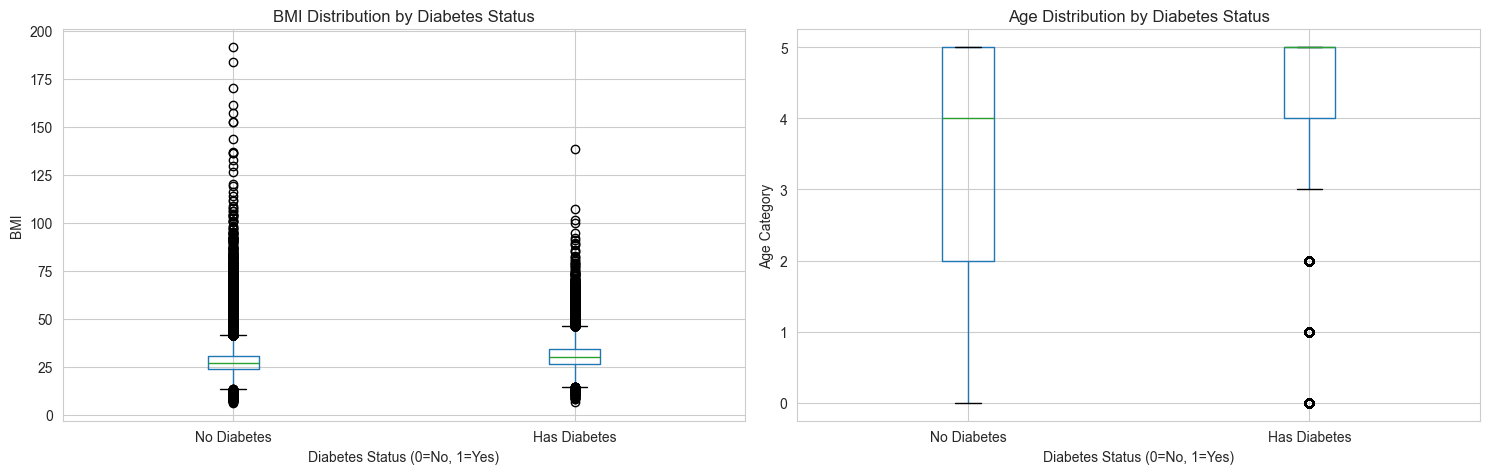

In [7]:
# Compare numerical features by diabetes status
if 'BMI' in data.columns and 'AGE' in data.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # BMI by diabetes status
    data.boxplot(column='BMI', by=target, ax=axes[0])
    axes[0].set_title('BMI Distribution by Diabetes Status')
    axes[0].set_xlabel('Diabetes Status (0=No, 1=Yes)')
    axes[0].set_ylabel('BMI')
    plt.sca(axes[0])
    plt.xticks([1, 2], ['No Diabetes', 'Has Diabetes'])
    
    # Age by diabetes status
    data.boxplot(column='AGE', by=target, ax=axes[1])
    axes[1].set_title('Age Distribution by Diabetes Status')
    axes[1].set_xlabel('Diabetes Status (0=No, 1=Yes)')
    axes[1].set_ylabel('Age Category')
    plt.sca(axes[1])
    plt.xticks([1, 2], ['No Diabetes', 'Has Diabetes'])
    
    plt.suptitle('')  # Remove automatic title
    plt.tight_layout()
    plt.show()

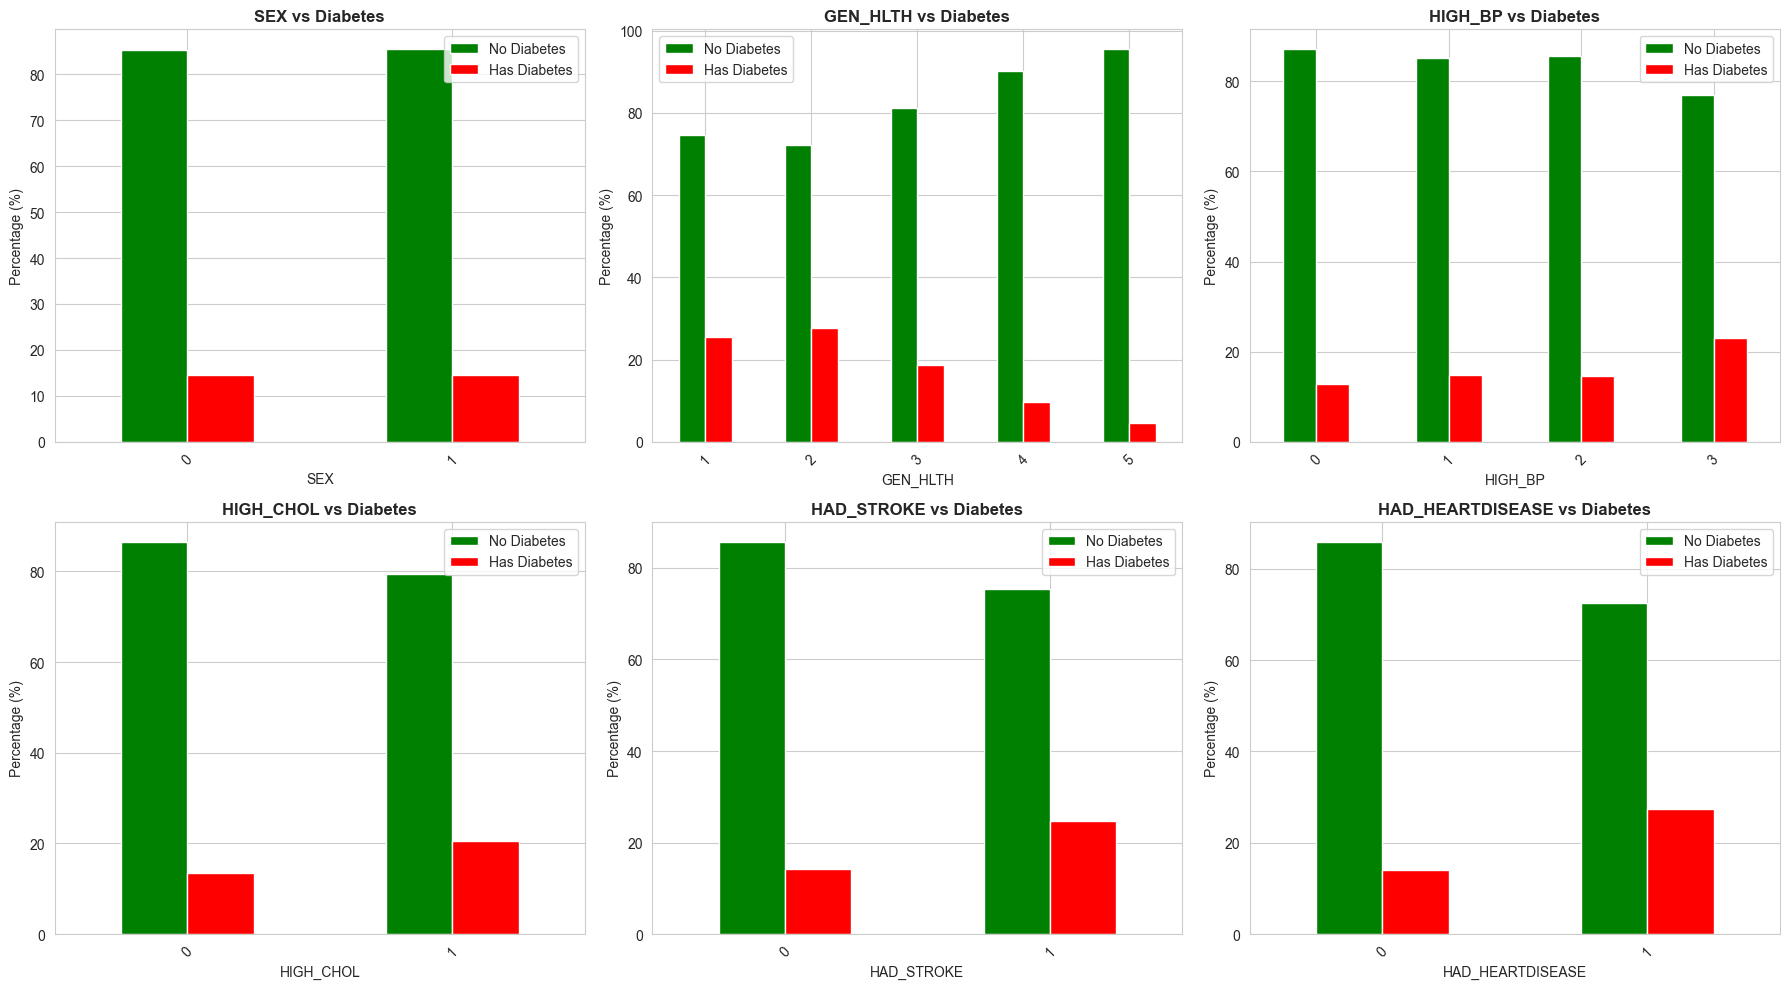

In [8]:
# Categorical features analysis
categorical_features = ['SEX', 'GEN_HLTH', 'HIGH_BP', 'HIGH_CHOL', 'HAD_STROKE', 'HAD_HEARTDISEASE']
existing_categorical = [col for col in categorical_features if col in data.columns]

if existing_categorical:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(existing_categorical[:6]):
        crosstab = pd.crosstab(data[col], data[target], normalize='index') * 100
        crosstab.plot(kind='bar', ax=axes[idx], color=['green', 'red'])
        axes[idx].set_title(f'{col} vs Diabetes', fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Percentage (%)')
        axes[idx].legend(['No Diabetes', 'Has Diabetes'])
        axes[idx].tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for idx in range(len(existing_categorical), 6):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

## 6. Correlation Analysis

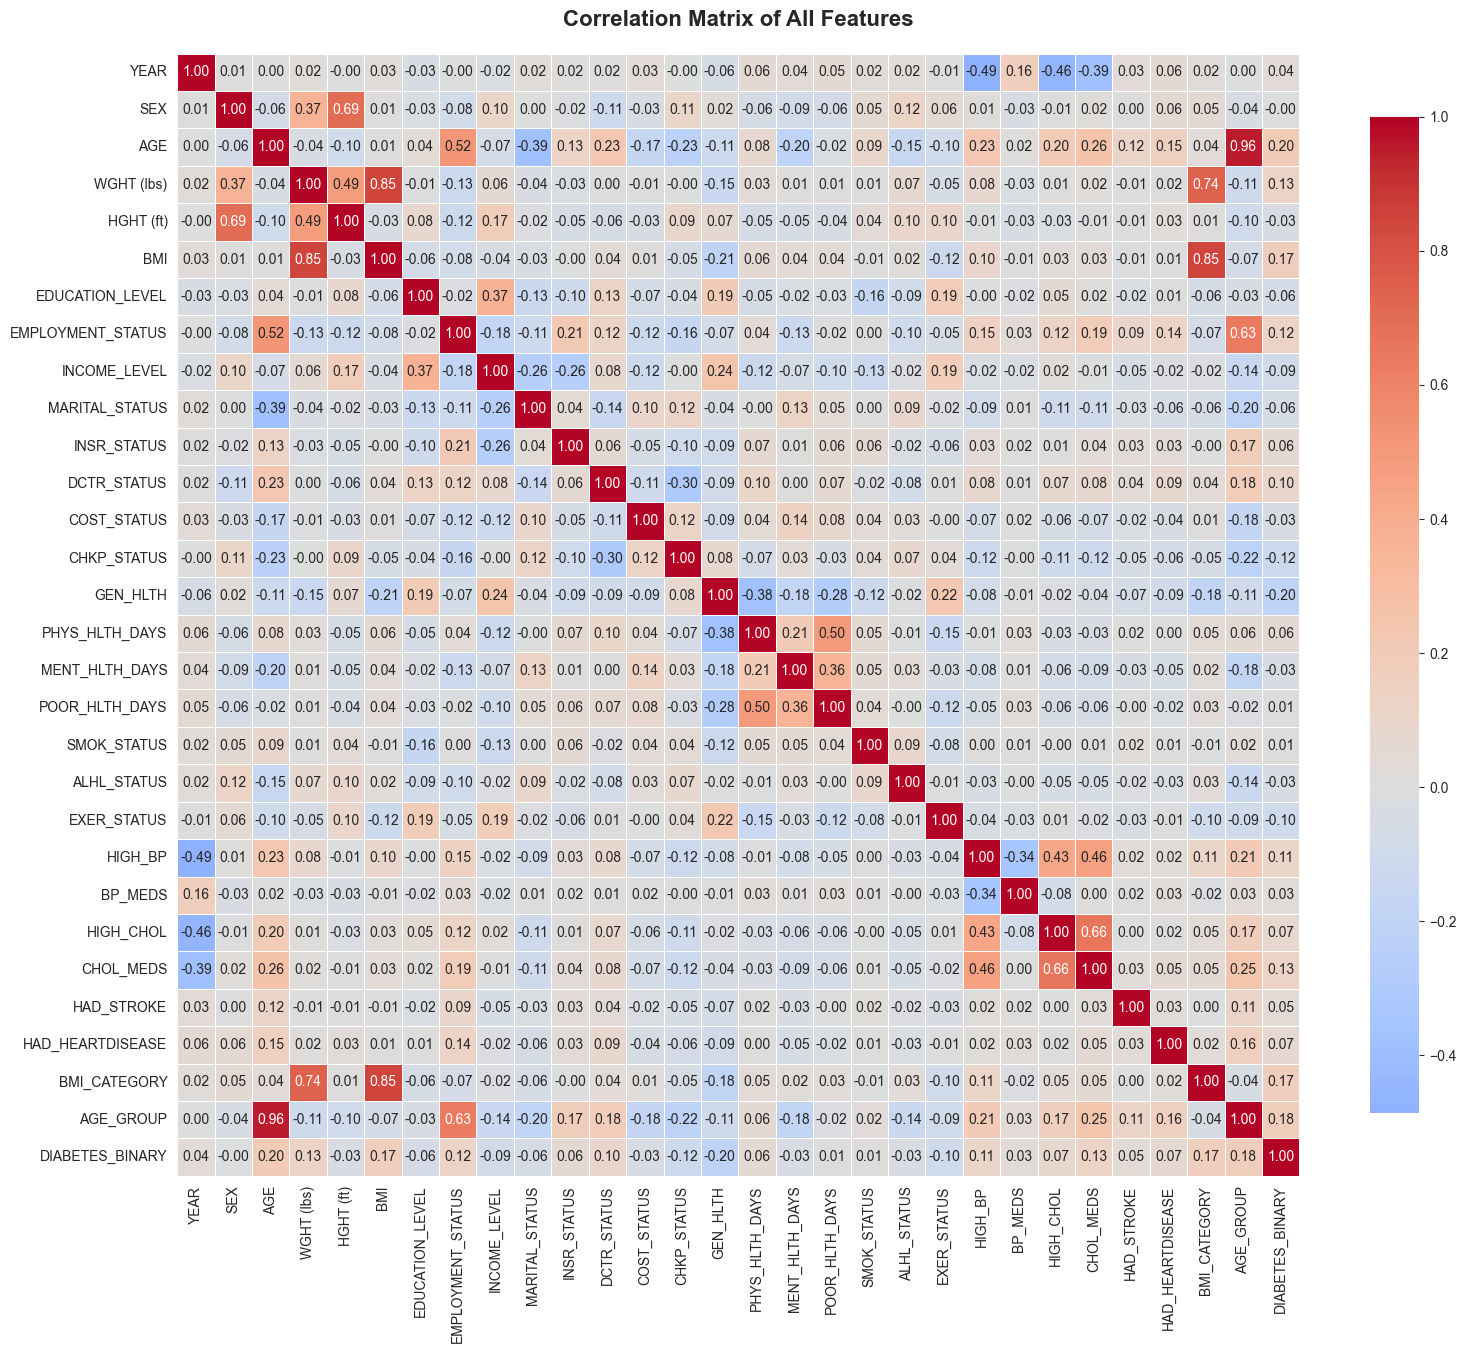

In [9]:
# Correlation matrix for all numerical features
plt.figure(figsize=(16, 14))
correlation_matrix = data[numerical_cols + [target]].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of All Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

Correlation with Target Variable (DIABETES_BINARY):
DIABETES_BINARY      1.000000
AGE                  0.204205
AGE_GROUP            0.177178
BMI                  0.168885
BMI_CATEGORY         0.165513
CHOL_MEDS            0.133393
WGHT (lbs)           0.132195
EMPLOYMENT_STATUS    0.120863
HIGH_BP              0.106265
DCTR_STATUS          0.097907
HIGH_CHOL            0.072390
HAD_HEARTDISEASE     0.069411
INSR_STATUS          0.061003
PHYS_HLTH_DAYS       0.058477
HAD_STROKE           0.047296
YEAR                 0.039556
BP_MEDS              0.026346
SMOK_STATUS          0.012038
POOR_HLTH_DAYS       0.008889
SEX                 -0.001684
MENT_HLTH_DAYS      -0.029400
ALHL_STATUS         -0.030835
HGHT (ft)           -0.031128
COST_STATUS         -0.031876
MARITAL_STATUS      -0.061984
EDUCATION_LEVEL     -0.062407
INCOME_LEVEL        -0.088552
EXER_STATUS         -0.098501
CHKP_STATUS         -0.124855
GEN_HLTH            -0.202872
Name: DIABETES_BINARY, dtype: float64


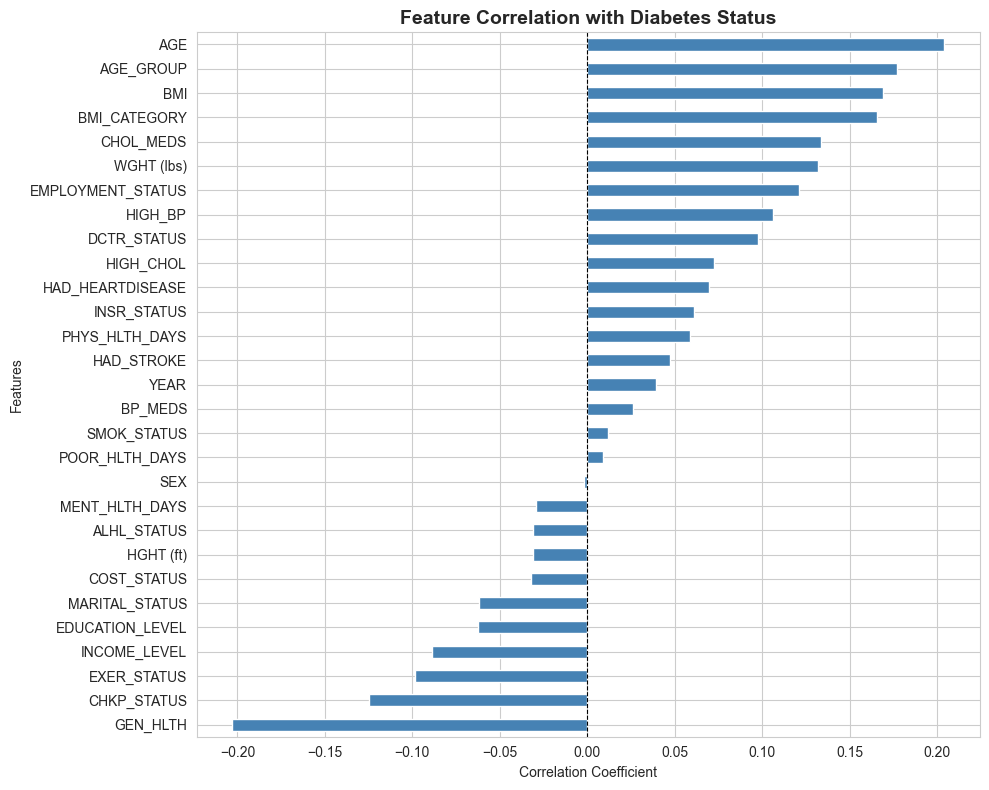

In [10]:
# Correlation with target variable
target_correlation = correlation_matrix[target].sort_values(ascending=False)
print("Correlation with Target Variable (DIABETES_BINARY):")
print(target_correlation)

# Visualize top correlations
plt.figure(figsize=(10, 8))
target_correlation[1:].sort_values().plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with Diabetes Status', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

## 7. Statistical Tests for Feature Importance

In [11]:
# Chi-square test for categorical variables
chi2_results = []

for col in data.columns:
    if col not in [target, 'DIABETES_STATUS', 'WGHT (lbs)', 'HGHT (ft)', 'BMI']:
        contingency_table = pd.crosstab(data[col], data[target])
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        chi2_results.append({
            'Feature': col,
            'Chi2_Statistic': chi2_stat,
            'P_Value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })

chi2_df = pd.DataFrame(chi2_results).sort_values('Chi2_Statistic', ascending=False)
print("Chi-Square Test Results (Top 15):")
display(chi2_df.head(15))

Chi-Square Test Results (Top 15):


,Feature,Chi2_Statistic,P_Value,Significant
11,GEN_HLTH,31339.796440,0.0,Yes
2,AGE,30644.168678,0.0,Yes
25,AGE_GROUP,21593.307817,0.0,Yes
4,EMPLOYMENT_STATUS,21236.294888,0.0,Yes
24,BMI_CATEGORY,20431.639665,0.0,Yes
10,CHKP_STATUS,13997.954400,0.0,Yes
7,INSR_STATUS,13388.453344,0.0,Yes
21,CHOL_MEDS,12936.952683,0.0,Yes
6,MARITAL_STATUS,9404.432014,0.0,Yes
8,DCTR_STATUS,8934.341496,0.0,Yes


## 8. Feature Selection Methods

### 8.1 SelectKBest with Chi2

In [12]:
# Prepare features and target
X = data.drop([target, 'DIABETES_STATUS'], axis=1, errors='ignore')
y = data[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check for and handle any remaining NaN values
print(f"\nNaN values in features: {X.isnull().sum().sum()}")
if X.isnull().sum().sum() > 0:
    print("Filling NaN values with 0 for feature selection...")
    X = X.fillna(0)

# Make all values non-negative for chi2
X_positive = X.copy()
for col in X_positive.columns:
    if X_positive[col].min() < 0:
        X_positive[col] = X_positive[col] - X_positive[col].min()

# SelectKBest with chi2
k_best = 15  # Select top 15 features
selector_chi2 = SelectKBest(chi2, k=k_best)
X_chi2 = selector_chi2.fit_transform(X_positive, y)

# Get selected features
chi2_scores = pd.DataFrame({
    'Feature': X.columns,
    'Chi2_Score': selector_chi2.scores_
}).sort_values('Chi2_Score', ascending=False)

print(f"\nTop {k_best} Features (Chi2):")
display(chi2_scores.head(k_best))

Features shape: (727123, 29)
Target shape: (727123,)

NaN values in features: 47114
Filling NaN values with 0 for feature selection...

Top 15 Features (Chi2):


,Feature,Chi2_Score
3,WGHT (lbs),141519.736598
15,PHYS_HLTH_DAYS,40425.376221
5,BMI,28387.730847
2,AGE,24288.504369
7,EMPLOYMENT_STATUS,23900.022128
21,HIGH_BP,20199.469687
28,AGE_GROUP,18096.579316
24,CHOL_MEDS,11447.995415
16,MENT_HLTH_DAYS,9152.638073
14,GEN_HLTH,7864.285894


### 8.2 SelectKBest with ANOVA F-statistic

In [13]:
# SelectKBest with ANOVA F-statistic
selector_f = SelectKBest(f_classif, k=k_best)
X_f = selector_f.fit_transform(X, y)

# Get selected features
f_scores = pd.DataFrame({
    'Feature': X.columns,
    'F_Score': selector_f.scores_
}).sort_values('F_Score', ascending=False)

print(f"Top {k_best} Features (ANOVA F-statistic):")
display(f_scores.head(k_best))

Top 15 Features (ANOVA F-statistic):


,Feature,F_Score
2,AGE,31639.950221
14,GEN_HLTH,31210.554412
28,AGE_GROUP,29437.245470
5,BMI,21347.900070
27,BMI_CATEGORY,20479.214405
24,CHOL_MEDS,13172.489020
3,WGHT (lbs),12932.908801
13,CHKP_STATUS,11514.464362
7,EMPLOYMENT_STATUS,10779.205026
21,HIGH_BP,8304.552462


### 8.3 Mutual Information

In [14]:
# SelectKBest with Mutual Information
selector_mi = SelectKBest(mutual_info_classif, k=k_best)
X_mi = selector_mi.fit_transform(X, y)

# Get selected features
mi_scores = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': selector_mi.scores_
}).sort_values('MI_Score', ascending=False)

print(f"Top {k_best} Features (Mutual Information):")
display(mi_scores.head(k_best))

Top 15 Features (Mutual Information):


,Feature,MI_Score
20,EXER_STATUS,0.122043
22,BP_MEDS,0.107343
13,CHKP_STATUS,0.082636
1,SEX,0.081581
28,AGE_GROUP,0.071265
14,GEN_HLTH,0.068131
19,ALHL_STATUS,0.059420
2,AGE,0.055672
11,DCTR_STATUS,0.055087
6,EDUCATION_LEVEL,0.054960


### 8.4 Random Forest Feature Importance

Top 15 Features (Random Forest):


,Feature,Importance
5,BMI,0.138407
3,WGHT (lbs),0.108805
4,HGHT (ft),0.080306
8,INCOME_LEVEL,0.071649
15,PHYS_HLTH_DAYS,0.050152
14,GEN_HLTH,0.045517
16,MENT_HLTH_DAYS,0.044887
6,EDUCATION_LEVEL,0.042790
9,MARITAL_STATUS,0.042474
10,INSR_STATUS,0.041439


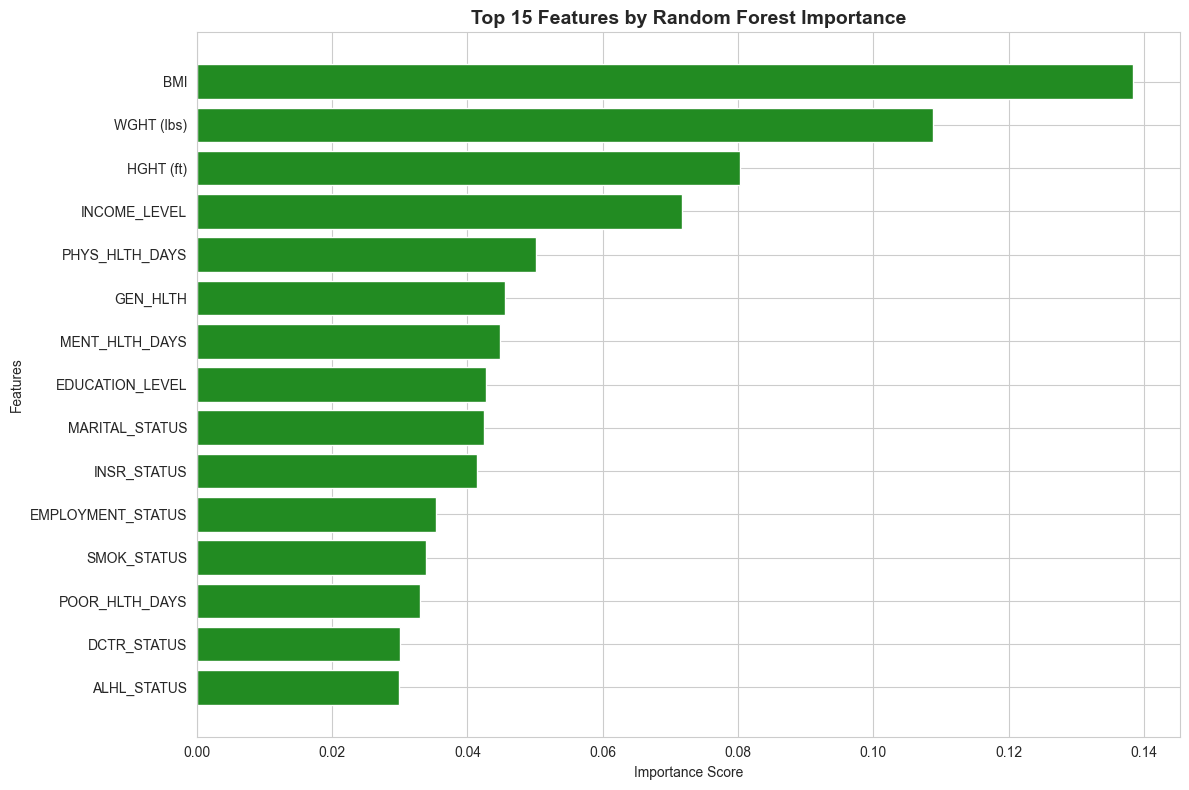

In [15]:
# Random Forest feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"Top {k_best} Features (Random Forest):")
display(rf_importance.head(k_best))

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(rf_importance.head(15)['Feature'], rf_importance.head(15)['Importance'], color='forestgreen')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 15 Features by Random Forest Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 8.5 Recursive Feature Elimination (RFE)

In [16]:
# RFE with Random Forest
estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rfe = RFE(estimator=estimator, n_features_to_select=k_best, step=1)
rfe.fit(X, y)

# Get selected features
rfe_selected = pd.DataFrame({
    'Feature': X.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
}).sort_values('Ranking')

print(f"\nTop {k_best} Features (RFE):")
display(rfe_selected.head(k_best))


Top 15 Features (RFE):


,Feature,Selected,Ranking
3,WGHT (lbs),True,1
2,AGE,True,1
5,BMI,True,1
4,HGHT (ft),True,1
6,EDUCATION_LEVEL,True,1
7,EMPLOYMENT_STATUS,True,1
9,MARITAL_STATUS,True,1
8,INCOME_LEVEL,True,1
15,PHYS_HLTH_DAYS,True,1
14,GEN_HLTH,True,1


## 9. Consolidated Feature Selection Results

In [17]:
# Combine all feature selection results
consolidated = pd.DataFrame({'Feature': X.columns})
consolidated = consolidated.merge(chi2_scores, on='Feature', how='left')
consolidated = consolidated.merge(f_scores, on='Feature', how='left')
consolidated = consolidated.merge(mi_scores, on='Feature', how='left')
consolidated = consolidated.merge(rf_importance, on='Feature', how='left')
consolidated = consolidated.merge(rfe_selected[['Feature', 'Ranking']], on='Feature', how='left')

# Normalize scores to 0-1 range for comparison
for col in ['Chi2_Score', 'F_Score', 'MI_Score', 'Importance']:
    if col in consolidated.columns:
        max_val = consolidated[col].max()
        if max_val > 0:
            consolidated[f'{col}_Normalized'] = consolidated[col] / max_val

# Calculate average rank
consolidated['Average_Score'] = consolidated[[
    'Chi2_Score_Normalized', 'F_Score_Normalized', 
    'MI_Score_Normalized', 'Importance'
]].mean(axis=1)

consolidated = consolidated.sort_values('Average_Score', ascending=False)

print("\nConsolidated Feature Importance (Top 20):")
display(consolidated[['Feature', 'Chi2_Score', 'F_Score', 'MI_Score', 'Importance', 'Average_Score']].head(20))


Consolidated Feature Importance (Top 20):


,Feature,Chi2_Score,F_Score,MI_Score,Importance,Average_Score
28,AGE_GROUP,18096.579316,29437.245470,0.071265,0.018719,0.415226
2,AGE,24288.504369,31639.950221,0.055672,0.028063,0.413964
14,GEN_HLTH,7864.285894,31210.554412,0.068131,0.045517,0.411441
3,WGHT (lbs),141519.736598,12932.908801,0.014449,0.108805,0.408987
20,EXER_STATUS,1412.314585,7123.959142,0.122043,0.015228,0.312591
5,BMI,28387.730847,21347.900070,0.019313,0.138407,0.292990
27,BMI_CATEGORY,6898.799989,20479.214405,0.054550,0.013939,0.289229
13,CHKP_STATUS,4694.436954,11514.464362,0.082636,0.013271,0.271866
7,EMPLOYMENT_STATUS,23900.022128,10779.205026,0.050923,0.035324,0.240535
22,BP_MEDS,11.678357,505.050605,0.107343,0.002768,0.224590


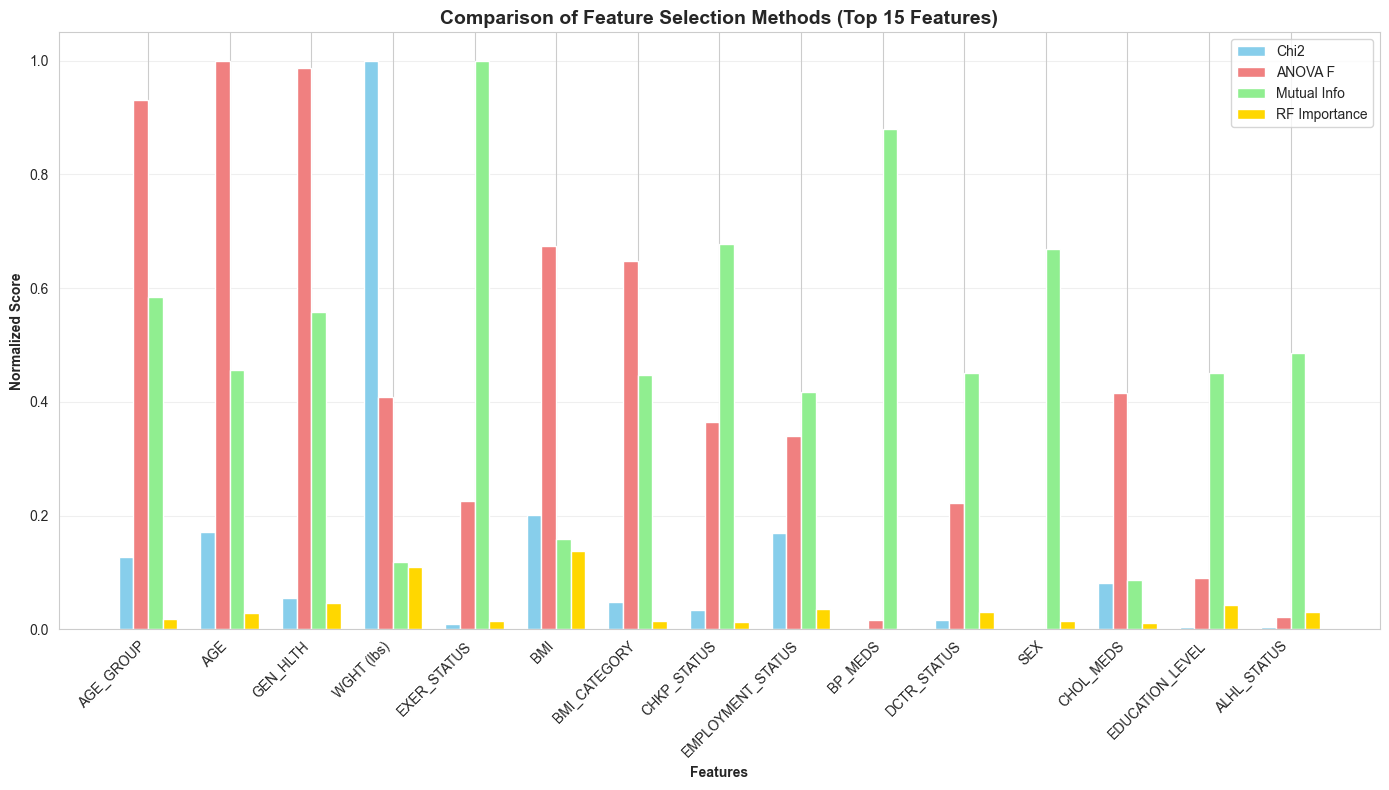

In [18]:
# Visualize consolidated scores
top_features = consolidated.head(15)

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(top_features))
width = 0.18

ax.bar(x - 1.5*width, top_features['Chi2_Score_Normalized'], width, label='Chi2', color='skyblue')
ax.bar(x - 0.5*width, top_features['F_Score_Normalized'], width, label='ANOVA F', color='lightcoral')
ax.bar(x + 0.5*width, top_features['MI_Score_Normalized'], width, label='Mutual Info', color='lightgreen')
ax.bar(x + 1.5*width, top_features['Importance'], width, label='RF Importance', color='gold')

ax.set_xlabel('Features', fontweight='bold')
ax.set_ylabel('Normalized Score', fontweight='bold')
ax.set_title('Comparison of Feature Selection Methods (Top 15 Features)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_features['Feature'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Final Selected Features

In [19]:
# Select top features based on average score
n_features = 15  # You can adjust this
selected_features = consolidated.head(n_features)['Feature'].tolist()

print(f"\nFinal {n_features} Selected Features:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

# Save selected features to file
with open('selected_features.txt', 'w') as f:
    for feature in selected_features:
        f.write(f"{feature}\n")

print("\nSelected features saved to 'selected_features.txt'")


Final 15 Selected Features:
1. AGE_GROUP
2. AGE
3. GEN_HLTH
4. WGHT (lbs)
5. EXER_STATUS
6. BMI
7. BMI_CATEGORY
8. CHKP_STATUS
9. EMPLOYMENT_STATUS
10. BP_MEDS
11. DCTR_STATUS
12. SEX
13. CHOL_MEDS
14. EDUCATION_LEVEL
15. ALHL_STATUS

Selected features saved to 'selected_features.txt'


## 11. Save Feature Importance Analysis

In [20]:
# Save consolidated feature importance
consolidated.to_csv('feature_importance_analysis.csv', index=False)
print("Feature importance analysis saved to 'feature_importance_analysis.csv'")

Feature importance analysis saved to 'feature_importance_analysis.csv'


## 12. Summary Statistics by Diabetes Status

In [21]:
# Summary statistics for selected features by diabetes status
print("Summary Statistics by Diabetes Status:\n")

for feature in selected_features[:5]:  # Show first 5 for brevity
    if feature in data.columns:
        print(f"\n{feature}:")
        print(data.groupby(target)[feature].describe())
        print("-" * 80)

Summary Statistics by Diabetes Status:


AGE_GROUP:
                    count      mean       std  min  25%  50%  75%  max
DIABETES_BINARY                                                       
0                575308.0  1.085471  0.813333  0.0  0.0  1.0  2.0  2.0
1                104739.0  1.480642  0.665386  0.0  1.0  2.0  2.0  2.0
--------------------------------------------------------------------------------

AGE:
                    count      mean       std  min  25%  50%  75%  max
DIABETES_BINARY                                                       
0                621509.0  3.245231  1.677980  0.0  2.0  4.0  5.0  5.0
1                105614.0  4.199396  1.146573  0.0  4.0  5.0  5.0  5.0
--------------------------------------------------------------------------------

GEN_HLTH:
                    count      mean       std  min  25%  50%  75%  max
DIABETES_BINARY                                                       
0                621509.0  3.586957  0.947856  1.0  3.0  4.

In [22]:
# Create final summary
print("="*80)
print("EDA & FEATURE SELECTION SUMMARY")
print("="*80)
print(f"Total features analyzed: {len(X.columns)}")
print(f"Features selected: {len(selected_features)}")
print(f"\nSelection criteria: Average of normalized scores from:")
print("  - Chi-Square Test")
print("  - ANOVA F-statistic")
print("  - Mutual Information")
print("  - Random Forest Importance")
print("  - Recursive Feature Elimination")
print(f"\nTop 5 Most Important Features:")
for i, feature in enumerate(selected_features[:5], 1):
    print(f"  {i}. {feature}")
print("="*80)

EDA & FEATURE SELECTION SUMMARY
Total features analyzed: 29
Features selected: 15

Selection criteria: Average of normalized scores from:
  - Chi-Square Test
  - ANOVA F-statistic
  - Mutual Information
  - Random Forest Importance
  - Recursive Feature Elimination

Top 5 Most Important Features:
  1. AGE_GROUP
  2. AGE
  3. GEN_HLTH
  4. WGHT (lbs)
  5. EXER_STATUS
